# Step 1

* Load scalar, waveform and image h5 files.
* For each sweep, interpolate images on regular y grid. 
* For each y and image pixel, interpolate x-x'. (f(x, x', y, y3, x3))
* For each (x, xp, y, x3), interpolate yp. (f(x, x', y, y', x3))
* For each (x, xp, y, yp), inteprolate w. (f(x, x', y, y', w)).

In [33]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
## tqdm.notebook might be causing a weird effect where notebook
## cells go blank when selected...
# from tqdm.notebook import tqdm
# from tqdm.notebook import trange
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from plotly import graph_objects as go
import proplot as pplt
from ipywidgets import interactive

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [6]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

Load info from step 0.

In [7]:
folder = '_output'

In [8]:
info = utils.load_pickle(join(folder, 'info.pkl'))
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29',
 'filename': '220429190854-scan-xxpy-image-ypdE',
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
   'center': 6.5,
   'distance': 14.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
   'center': 15.0,
   'distance': 24.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
   'center': 21.0,
   'distance': 17.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1. , 0. , 0. ],
        [0. , 1. , 1.9],
        [0. , 0. , 1. ]]),
 'ndim': 3,
 'cam': 'cam34',
 'cam_zoom': 0.5,
 'cam_pix2mm_y': 0.3,
 'cam_pix2mm_x': 0.2976190476190476,
 'cam_shape': (512, 612),
 'image_crop_edges': {'x1': 200, 'x2': 450, 'y1': 135, 'y2': 435},
 'image_offset': 28.0,
 'image_thresh': 98.0,
 'image_downscale': 3,
 'image_shape': (100, 84)}

In [9]:
datadir = info['datadir']
filename = info['filename']
datadir = info['datadir']
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('Attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

Attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (8400,))), 0))



## Scan overview

### Measured camera integral 

In [10]:
cam = info['cam']
scalar_diag = ['bcm04', f'{cam}_Integral', f'{cam}_Saturation']
acts = info['acts']
print('Scalar diagnostics:', scalar_diag)
print('Actuators:', acts)

Scalar diagnostics: ['bcm04', 'cam34_Integral', 'cam34_Saturation']
Actuators: ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']


Index of peak signal: 31474
Signal min = 0.10597099902119254


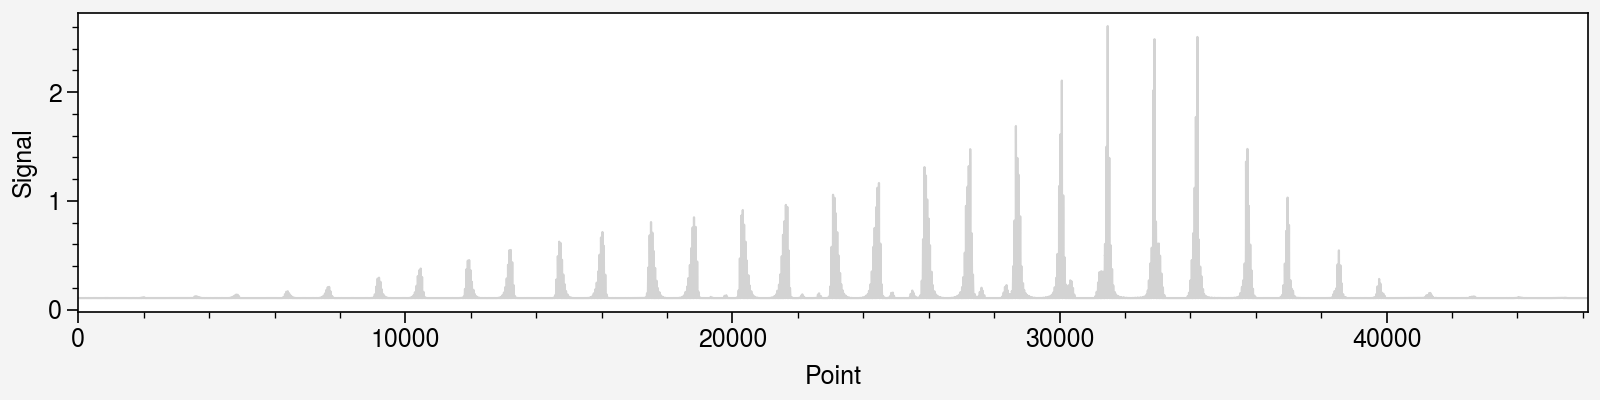

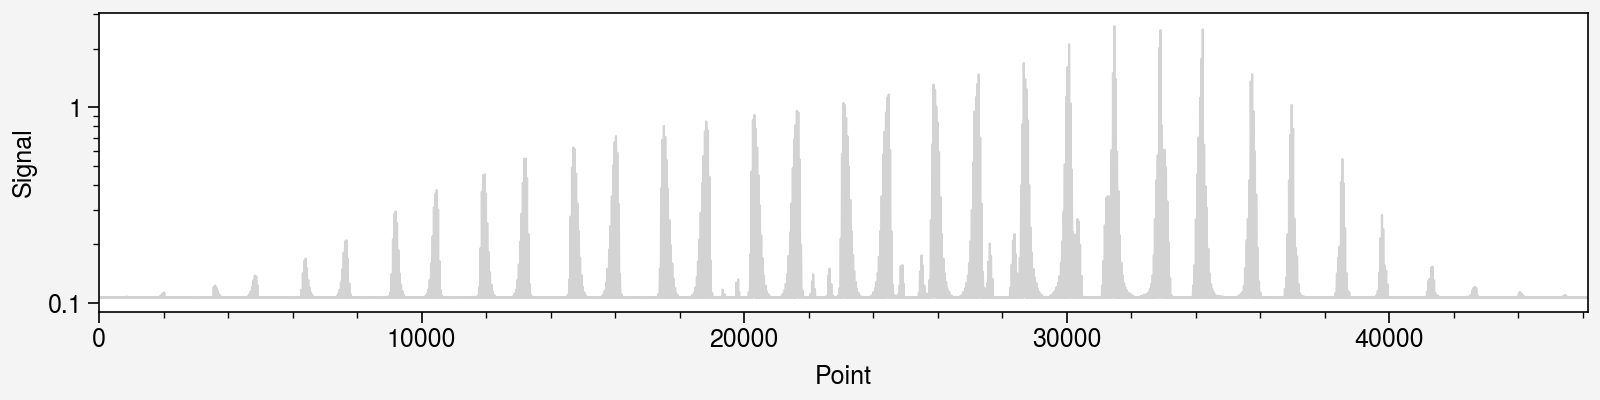

In [11]:
signal = np.copy(data_sc[:, cam + '_Integral'])
ipeak = np.argmax(signal)
print('Index of peak signal:', ipeak)
print(f'Signal min = {np.min(signal)}')

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(signal, lw=0.8, color='lightgrey')
    ax.format(yscale=yscale, ylabel='Signal', xlabel='Point')
    plt.savefig(f'_output/signal_raw_{yscale}.png')
    plt.show()

Subtract the offset from the signal and normalize to the range [0, 1]. Tune `thresh` until no black dots are in regions that clearly have no signal.

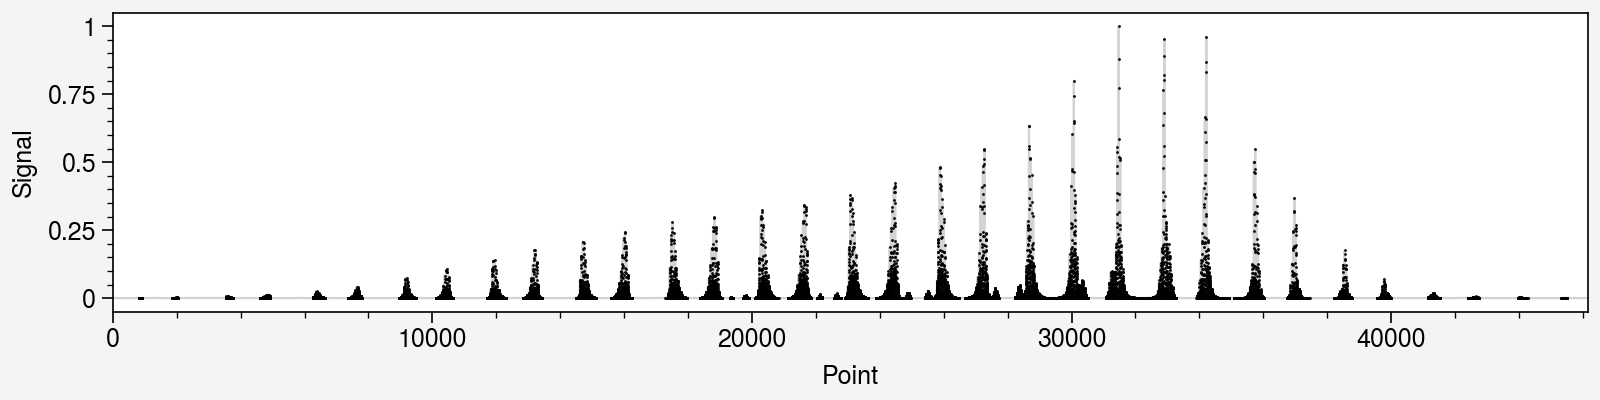

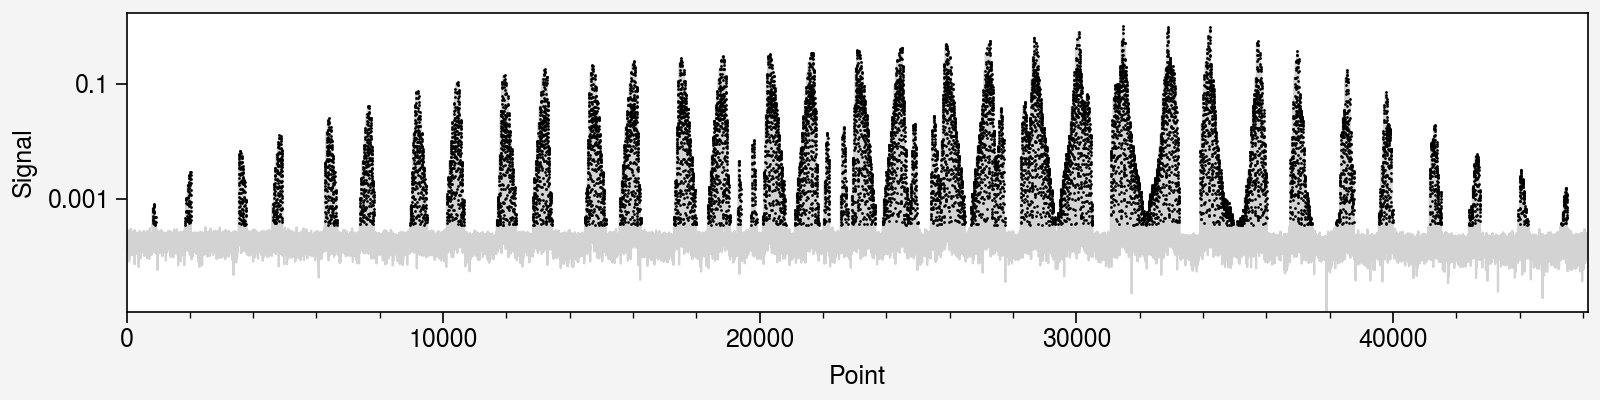

In [12]:
signal = signal - np.min(signal)
signal = signal / np.max(signal)
thresh = 0.00035  # fraction of max signal
valid, = np.where(signal >= thresh)

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(signal, color='lightgrey', lw=0.8)
    ax.plot(valid, signal[valid], lw=0, marker='.', ms=2, alpha=1, ec='None', color='black')
    ax.format(yscale=yscale, ylabel='Signal', xlabel='Point')
    plt.savefig(f'_output/signal_{yscale}.png')
    plt.show()

### Scan path

In [13]:
variables = info['variables']
variables

{'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
  'center': 6.5,
  'distance': 14.5,
  'steps': 32,
  'min': -50.0,
  'max': 50.0},
 'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
  'center': 15.0,
  'distance': 24.0,
  'steps': 32,
  'min': -50.0,
  'max': 50.0},
 'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
  'center': 21.0,
  'distance': 17.5,
  'steps': 32,
  'min': -50.0,
  'max': 50.0}}

In [14]:
keys = list(variables)
center = np.array([variables[key]['center'] for key in keys])
distance = np.array([variables[key]['distance'] for key in keys])
nsteps = np.array([variables[key]['steps'] for key in keys])
print(keys)

['y1', 'x2', 'x1']


In [15]:
ndim = info['ndim']
M = info['M']
Minv = np.linalg.inv(M)
print(M)

[[1.  0.  0. ]
 [0.  1.  1.9]
 [0.  0.  1. ]]


Extract the readback actuator points and normalize them.

In [16]:
points = np.vstack([data_sc[act] for act in acts]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)

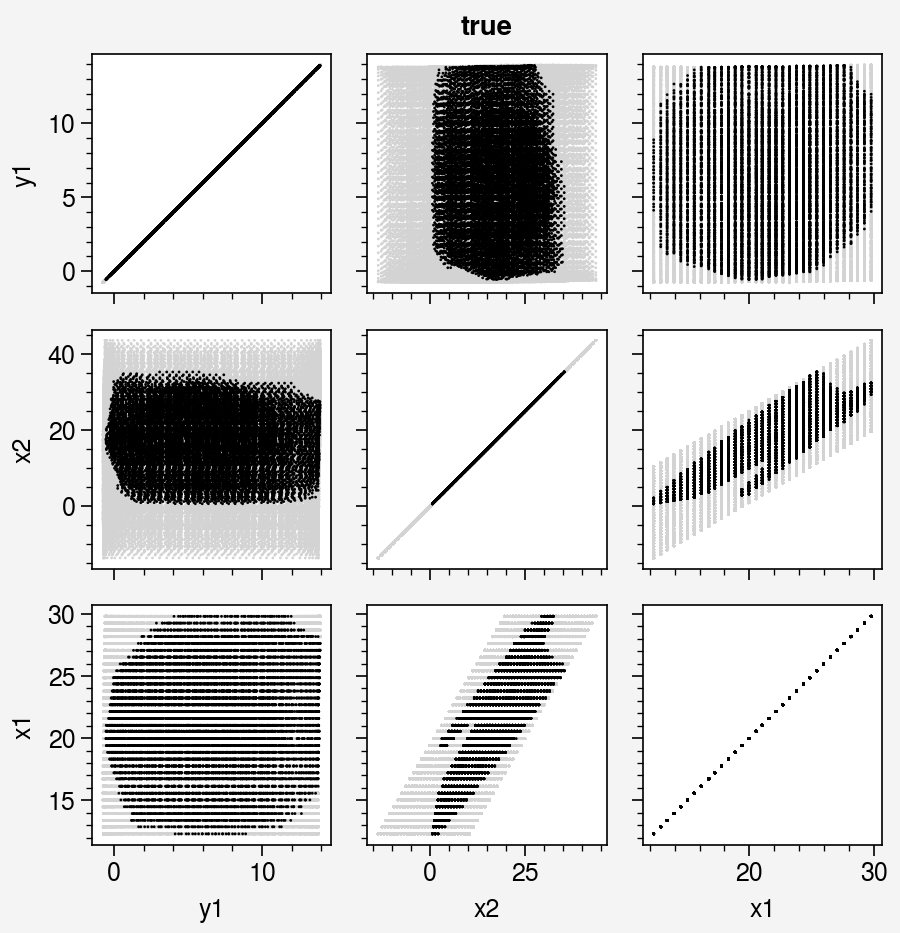

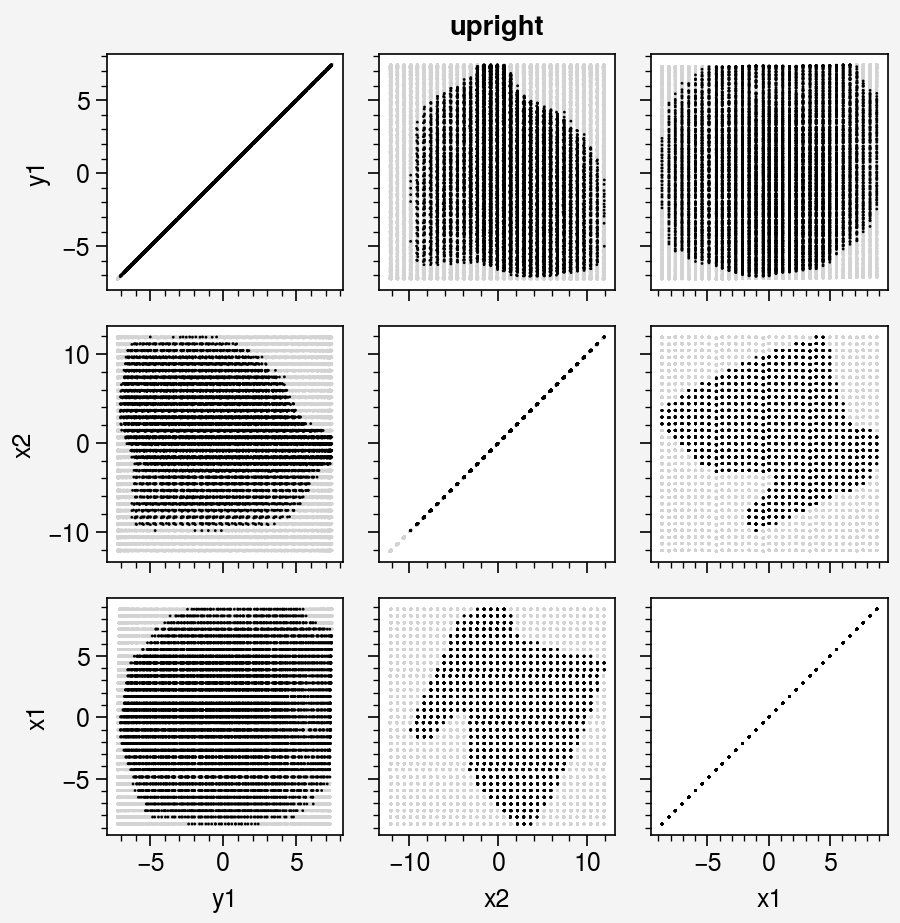

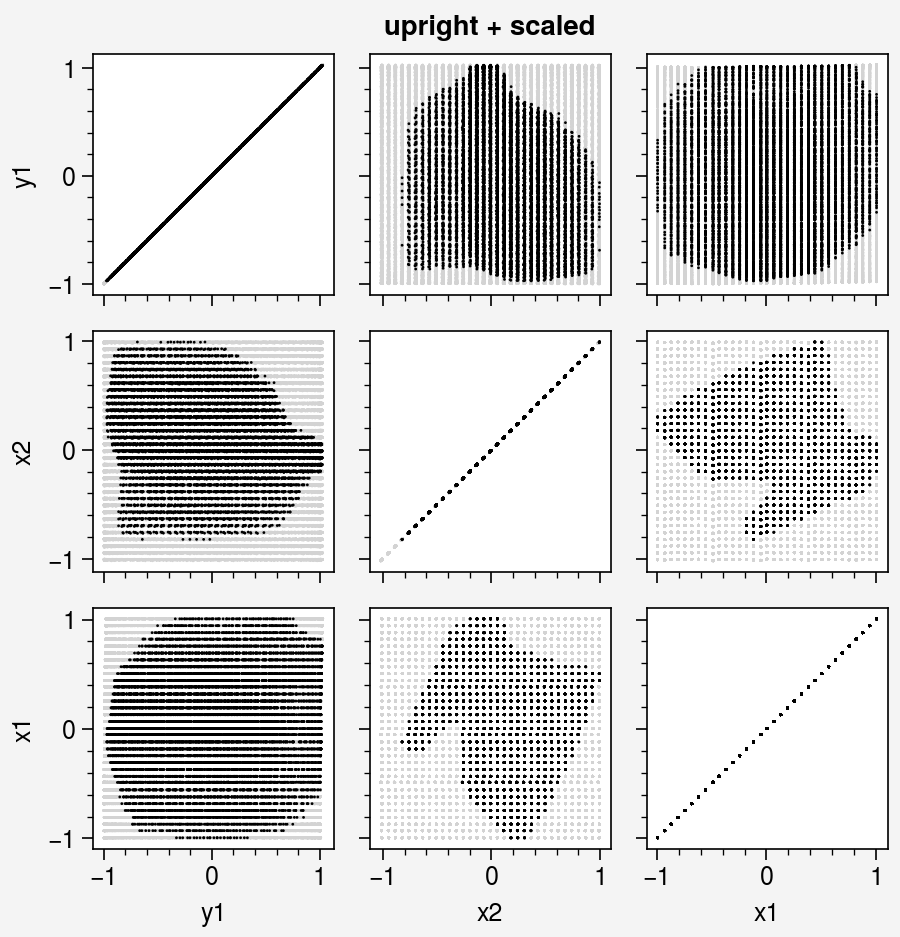

In [17]:
for _points, title in zip((points, points_n, points_nn), ('true', 'upright', 'upright + scaled')):
    fig, axes = pplt.subplots(ncols=3, nrows=3, figwidth=4.5, span=False)
    axes.format(suptitle=title)
    for i in range(3):
        for j in range(3):
            axes[i, j].scatter(_points[:, j], _points[:, i], c='lightgray', ec='None', s=1)
            axes[i, j].scatter(_points[valid, j], _points[valid, i], c='black', ec='None', s=1)
        axes[i, 0].format(ylabel=keys[i])
        axes[-1, i].format(xlabel=keys[i])
    plt.savefig(f'_output/points_{title}.png')
    plt.show()

3D interactive plot.

In [18]:
invalid, = np.where(signal < thresh)
x, y, z = points_nn[invalid, :].T.copy()
u, v, w = points_nn[valid, :].T.copy()
fig = go.Figure(
    data=[
        go.Scatter3d(x=x, y=y, z=z, mode='markers', 
                     marker=dict(color='lightgray', size=1, opacity=0.5)),
        go.Scatter3d(x=u, y=v, z=w, mode='markers', 
                     marker=dict(color='black', size=1, opacity=0.5)),
    ]
)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.update_layout(width=500, height=500)
fig.write_html('_output/points_nn3d.html')
# fig.show()

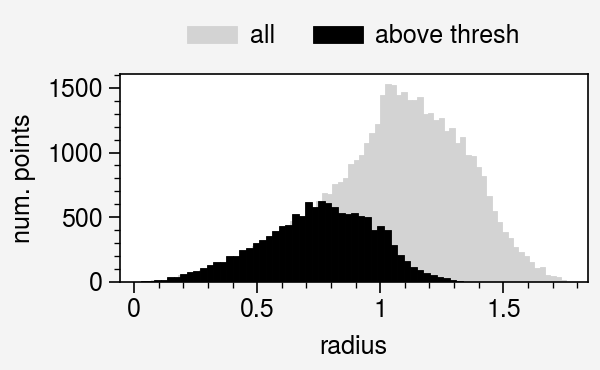

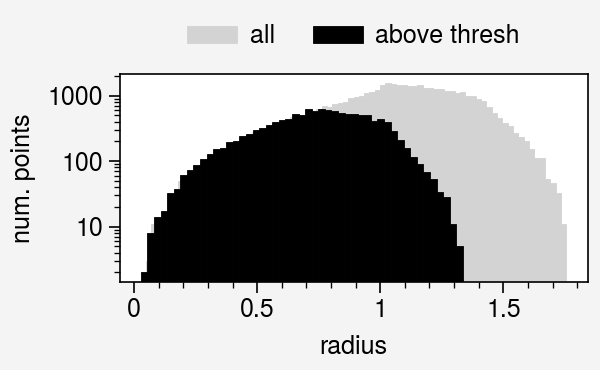

In [19]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))

with pplt.rc.context(legendfontsize='medium'):
    for yscale in [None, 'log']:
        fig, ax = pplt.subplots(figsize=(3, 1.85))
        ax.hist(radii, bins='auto', label='all', color='lightgrey')
        ax.hist(radii[valid], bins='auto', label='above thresh', color='black')
        ax.format(ylabel='num. points', xlabel='radius', yscale=yscale)
        ax.legend(ncols=2, loc='top', framealpha=0)
        plt.savefig(f'_output/radial_dist_{yscale}.png')
        plt.show()

## Interpolation 

### Interpolate y 

Define a regular $y$ grid.

In [20]:
nsteps = [variables[key]['steps'] for key in keys]
ygrid = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), int(nsteps[0]))

Interpolate the image stack along the $y$ axis on each iteration.

In [21]:
image_shape = info['image_shape']
iterations = data_sc['iteration']
images = data_im[cam + '_Image'].reshape((points.shape[0], image_shape[0], image_shape[1]))

In [24]:
iteration_nums = np.unique(iterations)
n_iterations = len(iteration_nums)
images_3D = np.zeros((n_iterations, nsteps[0], image_shape[0], image_shape[1]))
for iteration in tqdm(iteration_nums):
    idx = iterations == iteration
    fint = interpolate.interp1d(
        points[idx, 0],
        images[idx, :, :],
        axis=0,
        kind='linear', 
        bounds_error=False,
        fill_value=0.0, 
        assume_sorted=False,
    )
    images_3D[iteration - 1, ...] = fint(ygrid) 

  0%|          | 0/1089 [00:00<?, ?it/s]/home/46h/.venv/lib64/python3.9/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning:

invalid value encountered in true_divide

 30%|██▉       | 324/1089 [00:01<00:02, 290.98it/s]/home/46h/.venv/lib64/python3.9/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 1089/1089 [00:04<00:00, 246.71it/s]


In [27]:
def update(iteration, y):
    fig, ax = pplt.subplots()
    ax.imshow(images_3D[iteration - 1, y, :, :])
    ax.format(xlabel='y3', ylabel='x3')
    plt.show()
    
interactive(update, iteration=(1, n_iterations + 1), y=(0, nsteps[0] - 1))

interactive(children=(IntSlider(value=545, description='iteration', max=1090, min=1), IntSlider(value=15, desc…

### Interpolate x-x' 

Build the transfer matrices between the slits and the screen. (TO DO: Something needs to change sign for VS34 relative to VS06...)

In [28]:
a2mm = 1.009  # assume same for both dipoles
rho = 0.3556  # bend radius
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for first/last dipole-screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance
ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)
Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

Assume that $x_1$ and $x_2$ do not change on each iteration (or that the only variation is noise in the readback value). Select an $x$ and $x'$ for each $\left\{y, y_3, x_3\right\}$.

In [29]:
XXP = np.zeros((n_iterations, 2))
for iteration in iteration_nums:
    idx = iterations == iteration
    x2, x1 = np.mean(points[idx, 1:], axis=0)
    x = x1
    xp = 1e3 * ecalc.calculate_xp(x1 * 1e-3, x2 * 1e-3, Mslit)
    XXP[iteration - 1] = (x, xp)

Define the $x$-$x'$ interpolation grid. Tune `x_scale` and `xp_scale` to roughly align the grid points with the measured points.

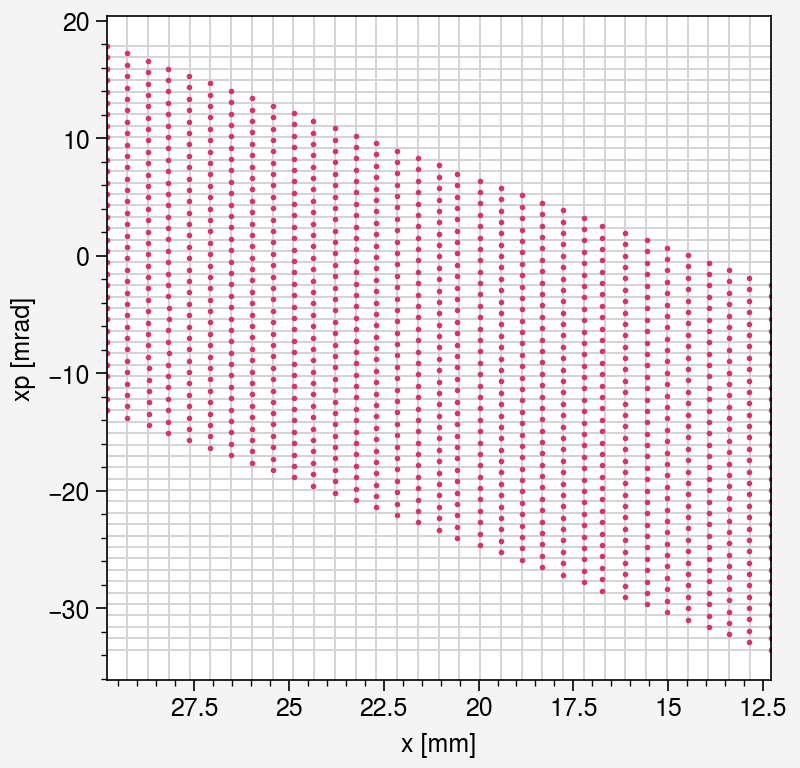

In [31]:
x_scale = 1.05
xp_scale = 1.7

x_min, xp_min = np.min(XXP, axis=0)
x_max, xp_max = np.max(XXP, axis=0)
xgrid = np.linspace(x_min, x_max, int(x_scale * nsteps[1]))
xpgrid = np.linspace(xp_min, xp_max, int(xp_scale * nsteps[2]))
XXP_new = utils.get_grid_coords(xgrid, xpgrid, indexing='ij')

fig, ax = pplt.subplots(figwidth=4)
line_kws = dict(color='lightgray', lw=0.7)
for x in xgrid:
    g1 = ax.axvline(x, **line_kws)
for xp in xpgrid:
    ax.axhline(xp, **line_kws)
ax.plot(XXP[:, 0], XXP[:, 1], color='pink7', lw=0, marker='.', ms=2)
ax.format(xlabel='x [mm]', ylabel='xp [mrad]')
plt.savefig('_output/xxp_interp_grid.png')

Interpolate $x$-$x'$ for each $\left\{y, y_3, x_3\right\}$.

In [ ]:
shape = (len(xgrid), len(xpgrid), len(ygrid), image_shape[0], image_shape[1])
f = np.zeros(shape)
for k in trange(shape[2]):
    for l in trange(shape[3]):
        for m in range(shape[4]):
            new_values = interpolate.griddata(
                XXP,
                images_3D[:, k, l, m],
                XXP_new,
                method='linear',
                fill_value=False,
            )
            f[:, :, k, l, m] = new_values.reshape((shape[0], shape[1]))

 88%|████████▊ | 88/100 [01:46<00:14,  1.21s/it]

### Interpolate y'

Convert $x_3$ and $y_3$ to mm.

In [ ]:
pix2mm_x = info['cam_pix2mm_x']
pix2mm_y = info['cam_pix2mm_y']
x3grid = np.arange(image_shape[1]) * pix2mm_x
y3grid = np.arange(image_shape[0]) * pix2mm_y

Tune `ypgrid_scale` to align the new $y'$ grid will the transformed points.

In [ ]:
ypgrid_scale = 1.1  # scales resolution of y' interpolation grid

# Get min/max y'.
_Y, _Y3 = np.meshgrid(ygrid, y3grid, indexing='ij')
_YP = 1e3 * ecalc.calculate_yp(_Y * 1e-3, _Y3 * 1e-3, Mscreen)  # [mrad]
ypgrid = np.linspace(np.min(_YP), np.max(_YP), int(ypgrid_scale * image_shape[0]))

fig, ax = pplt.subplots(figwidth=4)
for yp in ypgrid:
    ax.axhline(yp, **line_kws)
ax.plot(_Y.ravel(), _YP.ravel(), color='pink7', lw=0, marker='.', ms=2)
ax.format(xlabel='y [mm]', ylabel='yp [mrad]')
plt.show()

The $y$ coordinate is already on a grid. For each $\left{x, x', y, x3\right}$, transform $y_3 \rightarrow y'$ and interpolate onto `ypgrid`. 

In [ ]:
shape = (len(xgrid), len(xpgrid), len(ygrid), len(ypgrid), image_shape[1])
f_new = np.zeros(shape)
for i in trange(shape[0]):
    for j in trange(shape[1]):
        for k in range(shape[2]):
            for m in range(shape[4]): 
                y = ygrid[k]
                yp = 1e3 * ecalc.calculate_yp(y * 1e-3, y3grid * 1e-3, Mscreen)
                fint = interpolate.interp1d(
                    yp,
                    f[i, j, k, :, m], 
                    kind='linear', 
                    fill_value=0.0, 
                    bounds_error=False,
                    assume_sorted=False,
                )
                f_new[i, j, k, :, m] = fint(ypgrid)

In [ ]:
f = f_new.copy()

### Interpolate w

Form the grid for the energy spread $w$.

In [ ]:
# Compute min/max 
_W = np.zeros((shape[0], shape[1], image_shape[1]))
for i in range(shape[0]):
    for j in range(shape[1]):
        x = xgrid[i]
        xp = xpgrid[j]
        _W[i, j, :] = ecalc.calculate_dE_screen(x3grid * 1e-3, 0.0, x * 1e-3, xp * 1e-3, Mscreen)  # [MeV]
        
wgrid = np.linspace(np.min(_W), np.max(_W), image_shape[1])

In [ ]:
# savefilename = f'_output/f_test.mmp'
# f_new = np.memmap(savefilename, shape=shape, dtype='float', mode='w+') 
f_new = np.zeros(shape)
for i in trange(shape[0]):
    for j in trange(shape[1]):
        for k in range(shape[2]):
            for l in range(shape[3]):
                fint = interpolate.interp1d(
                    _W[i, j, :],
                    f[i, j, k, l, :],
                    kind='linear',
                    fill_value=0.0, 
                    bounds_error=False,
                    assume_sorted=False,
                )
                f_new[i, j, k, l, :] = fint(wgrid)

In [ ]:
f = f_new.copy()

In [ ]:
# Save coordinate arrays.
coords = [xgrid, xpgrid, ygrid, ypgrid, wgrid]
for i in range(5):
    coords[i] = coords[i] - np.mean(coords[i])
utils.save_stacked_array(f'_output/coords_{filename}.npy', coords)

In [ ]:
mplt.interactive_proj2d(f, 
                        # coords=coords, 
                        dims=["x", "xp", "y", "yp", "w"],
                        units=["mm", "mrad", "mm", "mrad", "MeV"])